# Preparation

In [1]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

In [2]:
OUTPUT_PATH = "/kaggle/working"
DATASET1_PATH = "/kaggle/input/snooker-balls/balls"#Snooker Balls: balls
DATASET2_PATH = "/kaggle/input/d/anamariamelinte/snooker-balls/not_balls/not_balls"#Snooker balls: balls, not_balls

# Dataset 

### Original Dataset1 Structure
Dataset1 structure is given in next format:
```
snooker-balls/balls/
    train/
        {class1}/
            {id_1}.jpg
            {id_2}.jpg
            ...
        {class2}/
            ...
        ...
    test/
    ...
```

### Yolo Dataset Structure
Dataset structure should be transformed to next format:
```
yolo_dataset/
    images/
        train/
            {class1}_{id_1}.jpg
            {class1}_{id_2}.jpg
            ...
        val/
            ...
    labels/
        train/
            {class1}_{id_1}.txt
            {class1}_{id_2}.txt
            ...
        val/
            ...
```

In [3]:
# root directory to save dataset in yolo format
root_dir=os.path.join(OUTPUT_PATH,"yolo_dataset")
os.makedirs(root_dir, exist_ok=True)

# train and test subdirectories with image directory
images_dir=os.path.join(root_dir,"images")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(images_dir+"/train", exist_ok=True)
os.makedirs(images_dir+"/val", exist_ok=True)

# train and test subdirectories with label directory
labels_dir=os.path.join(root_dir,"labels")
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(labels_dir+"/train", exist_ok=True)
os.makedirs(labels_dir+"/val", exist_ok=True)

In [4]:
# variables to convert label/id to id/label
label2id = {"black": 0, "blue": 1, "brown": 2, "green": 3, "pink": 4, "red": 5, "white": 6, "yellow": 7}
id2label = {v: k for k, v in label2id.items()}

In [5]:
for layer1 in os.listdir(DATASET1_PATH):
    for layer2 in os.listdir(f'{DATASET1_PATH}/{layer1}'):
        for layer3 in os.listdir(f'{DATASET1_PATH}/{layer1}/{layer2}'):
            if layer3.endswith('.jpg'):
                shutil.copyfile(f'{DATASET1_PATH}/{layer1}/{layer2}/{layer3}',f'{images_dir}/{layer1}/{layer2}_{layer3}'.replace('test', 'val' ))
                f = open(f'{labels_dir}/{layer1}/{layer2}_{layer3}'[:-4].replace('test', 'val' )+'.txt', 'w')
                f.write(str(label2id[layer2])+' 0.5 0.5 1 1')
                f.close()

### Original Dataset2 Structure
Dataset2 structure is given in next format:
```
snooker-balls/not_balls/not_balls/
    {id_1}.jpg
    {id_2}.jpg
    ...
    new_old/
        #unused
        ...
    old/
        #unused
        ...
```

### Yolo Dataset Structure
Dataset structure should be transformed to next format:
```
yolo_dataset/
    images/
        train/
            not_{id_1}.jpg
            not_{id_2}.jpg
            ...
        val/
            ...
    labels/
        train/
            not_{id_1}.txt
            not_{id_2}.txt
            ...
        val/
            ...
```

In [6]:
for img_id in os.listdir(DATASET2_PATH):
    if img_id.endswith('1.jpg'):
        shutil.copyfile(f'{DATASET2_PATH}/{img_id}',f'{images_dir}/val/not_{img_id}')
        f = open(f'{labels_dir}/val/not_{img_id}'[:-4]+'.txt', 'w')
        f.close()
    elif img_id.endswith('.jpg'):
        shutil.copyfile(f'{DATASET2_PATH}/{img_id}',f'{images_dir}/train/not_{img_id}')
        f = open(f'{labels_dir}/train/not_{img_id}'[:-4]+'.txt', 'w')
        f.close()

# YOLOv8

In [7]:
!pip install ultralytics
!yolo checks
from ultralytics import YOLO

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/98/44/71231f2da4fb4a602d0cef2071adb708199e571ef89ed4a136f59c19d733/ultralytics-8.0.231-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 11.5 MB/s eta 0:00:00a 0:00:01
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5310.5/8062.4 GB disk)

OS                  Linux-5.15.133+-x86_64-with-glibc2.31
Environment         Kaggle
Python              3.10.12
Install             pip
RAM                 31.36 GB
CPU                 Intel Xeon 2.20GHz
CUDA                None

matplotlib          ✅ 3.7.4>=3.3.0
numpy               ✅ 1.24.3>=1.22.2
opencv-python       ✅ 4.8.1.78>=4.6.0
pillow              ✅ 9.5.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.0.0+cpu>=1.8.0
torchvision         ✅ 0.15.1+cpu

### Convert Dataset to Yolo Format

In [8]:
names_content = "\n".join([f"  {label_id}: {label}" for label, label_id in label2id.items()])
dataset_content = f"""
path: "{root_dir}/"
train: "images/train"
val: "images/val"
names:
{names_content}
"""
with open(os.path.join(OUTPUT_PATH, "custom_dataset.yaml"), "w") as f:
    f.write(dataset_content)

### Train the Model

In [30]:
# pretrained model: yolov8n、yolov8s、yolov8m、yolov8l、yolov8x
model = YOLO('yolov8n-p2.yaml').load('yolov8n.pt')

# Train the model using the processed dataset
results = model.train(
    data=os.path.join(OUTPUT_PATH,'custom_dataset.yaml'),
    project='snooker_project',
    exist_ok=True,
    epochs=10,
    batch=8,
    imgsz=16,
    optimizer='Adam',
    lr0=0.001,
    lrf=0.0005
)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

wandb: Currently logged in as: yustinachang. Use `wandb login --relogin` to force relogin


Freezing layer 'model.28.dfl.conv.weight'
WARNING ⚠️ imgsz=[16] must be multiple of max stride 32, updating to [32]


train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 13575 images, 2065 backgrounds, 0 corrupt: 100%|██████████| 13575/13575 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 3103 images, 230 backgrounds, 0 corrupt: 100%|██████████| 3103/3103 [00:00<?, ?it/s]


Plotting labels to snooker_project/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 70 weight(decay=0.0), 79 weight(decay=0.0005), 78 bias(decay=0.0)
WARNING ⚠️ TensorBoard graph visualization failure Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.6798      1.182      1.274          6         32: 100%|██████████| 1697/1697 [04:02<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:21<00:00,  8.97it/s]


                   all       3103       2873      0.784      0.743      0.896      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.3259     0.5318     0.9974          6         32: 100%|██████████| 1697/1697 [03:37<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:19<00:00, 10.05it/s]


                   all       3103       2873      0.827      0.915      0.975      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.2698     0.4023     0.9614          5         32: 100%|██████████| 1697/1697 [04:17<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:19<00:00,  9.98it/s]


                   all       3103       2873      0.911      0.921      0.978      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      0.242     0.3356      0.949          7         32: 100%|██████████| 1697/1697 [03:37<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:18<00:00, 10.23it/s]


                   all       3103       2873      0.922      0.906      0.981       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.2271     0.3122     0.9427          5         32: 100%|██████████| 1697/1697 [03:26<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:22<00:00,  8.47it/s]


                   all       3103       2873      0.941      0.923       0.98      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.2129     0.2771     0.9362          5         32: 100%|██████████| 1697/1697 [03:43<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:51<00:00,  3.78it/s]


                   all       3103       2873      0.829      0.938      0.969      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.1999     0.2535     0.9339          6         32: 100%|██████████| 1697/1697 [03:52<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:29<00:00,  6.54it/s]


                   all       3103       2873       0.87      0.956      0.977      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.1921     0.2353     0.9251          5         32: 100%|██████████| 1697/1697 [03:29<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:47<00:00,  4.09it/s]

                   all       3103       2873      0.865      0.958      0.982      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.1822     0.2206     0.9246          6         32: 100%|██████████| 1697/1697 [03:50<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [01:13<00:00,  2.63it/s]

                   all       3103       2873      0.886      0.941      0.985      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.1731      0.206     0.9241          5         32: 100%|██████████| 1697/1697 [04:40<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [02:19<00:00,  1.39it/s]

                   all       3103       2873        0.9      0.947      0.986      0.843



10 epochs completed in 0.772 hours.
Optimizer stripped from snooker_project/train/weights/last.pt, 6.1MB
Optimizer stripped from snooker_project/train/weights/best.pt, 6.1MB

Validating snooker_project/train/weights/best.pt...
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
YOLOv8n-p2 summary (fused): 207 layers, 2922096 parameters, 0 gradients, 12.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 194/194 [00:18<00:00, 10.62it/s]


                   all       3103       2873      0.886      0.942      0.985      0.852
                 black       3103        359       0.98      0.978      0.984      0.821
                  blue       3103        323      0.992        0.8      0.992      0.844
                 brown       3103        331      0.859      0.985      0.987      0.799
                 green       3103        239      0.995      0.979      0.995      0.869
                  pink       3103         42      0.983      0.976      0.994      0.813
                   red       3103        322      0.922      0.823      0.942      0.858
                 white       3103       1233          1      0.993      0.995      0.902
                yellow       3103         24       0.36          1      0.995      0.913
Speed: 0.0ms preprocess, 3.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to snooker_project/train


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▃▆█▇▇▆▅▃▂▁
lr/pg2,▃▆█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▇▇██▇▇███
metrics/mAP50-95(B),▁▇▆▇█▇▇▇██
metrics/precision(B),▁▃▇▇█▃▅▅▆▆
metrics/recall(B),▁▇▇▆▇▇██▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▃▂▂▂▂▁▁▁▁


### Validate the Model

In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

### Export the Model with **ONNX**

In [ ]:
model.export(format='onnx')

### Benchmark the Model with **ONNX**

In [ ]:
from ultralytics.utils.benchmarks import benchmark
benchmark(model='snooker_project/train/weights/best.pt', imgsz=128)

### Create a Download Link

In [ ]:
%cd $OUTPUT_PATH
!zip -r snooker_project.zip snooker_project
from IPython.display import FileLink
FileLink(r'snooker_project.zip')

# Image from Test

In [31]:
image = '/kaggle/input/snooker-private-test/image2.jpg'

In [32]:
%cd $OUTPUT_PATH
best_model = YOLO("snooker_project/train/weights/best.pt")
best_model.predict(source=image, show=False, save=True, name='image', exist_ok=True)

/kaggle/working

image 1/1 /kaggle/input/snooker-private-test/image2.jpg: 32x32 (no detections), 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 32)
Results saved to runs/detect/image


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'black', 1: 'blue', 2: 'brown', 3: 'green', 4: 'pink', 5: 'red', 6: 'white', 7: 'yellow'}
 orig_img: array([[[  0, 168,   0],
         [  0, 168,   0],
         [  0, 168,   0],
         ...,
         [  0, 173,   0],
         [  0, 173,   0],
         [  0, 172,   0]],
 
        [[  0, 168,   0],
         [  0, 168,   0],
         [  0, 168,   0],
         ...,
         [  0, 172,   0],
         [  0, 172,   0],
         [  0, 172,   0]],
 
        [[  0, 169,   0],
         [  0, 169,   0],
         [  0, 168,   0],
         ...,
         [  0, 171,   0],
         [  0, 171,   0],
         [  0, 171,   0]],
 
        ...,
 
        [[  0, 190,   8],
         [  0, 190,   8],
         [  0, 190,   8],
         ...,
         [  0, 193,   7],
         [  0, 193,   7],
         [  0, 192,   7]],
 
        [[  0, 191,   6],
         [  0, 

/kaggle/working


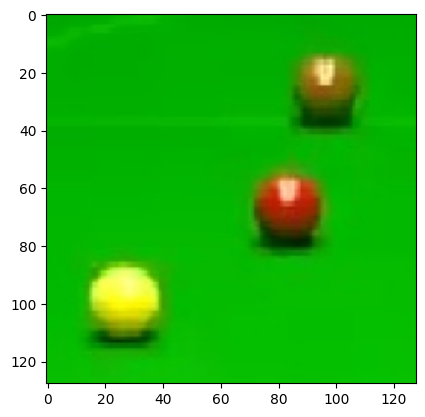

In [33]:
%cd $OUTPUT_PATH
plt.imshow(cv2.cvtColor(cv2.imread('runs/detect/image/image2.jpg'), cv2.COLOR_BGR2RGB))
plt.show()

# Video with PyTube

In [ ]:
!pip install pytube
from pytube import YouTube
YouTube('https://youtu.be/hw02UKK4Kb0').streams.filter().get_highest_resolution().download(output_path=OUTPUT_PATH, filename='youtube.mp4')

In [ ]:
%cd $OUTPUT_PATH
!ffmpeg -i youtube.mp4 -vcodec copy -acodec copy -ss 00:01:05 -to 00:01:15 video.mp4 -y

In [ ]:
%cd $OUTPUT_PATH
Video('video.mp4', width=840)

In [15]:
#video = os.path.join(OUTPUT_PATH, 'video.mp4')
video = '/kaggle/input/snooker-private-test/video.mp4'

# Predict the Video

In [16]:
%cd $OUTPUT_PATH
best_model = YOLO("snooker_project/train/weights/best.pt")
best_model.predict(source=video, show=False, save=True, name='predict', exist_ok=True)

/kaggle/working


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/226) /kaggle/input/snooker-private-test/video.mp4: 64x64 (no detections), 23.8ms
video 1/1 (2/226) /kaggle/input/snooker-private-test/video.mp4: 64x64 (no detections), 15.8ms
video 1/1 (3/226) /kaggle/input/snooker-private-test/video.mp4: 64x64 (no detections), 12.0ms
video 1/1 (4/226) /kaggle/input/snooker-private-test/video.mp4: 64x64 (no detections), 11.4ms
video 1/1 (5/226) /kaggle/input/snooker-private-test/video.mp4: 

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'black', 1: 'blue', 2: 'brown', 3: 'green', 4: 'pink', 5: 'red', 6: 'white', 7: 'yellow'}
 orig_img: array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  4,  0],
         [ 0,  4,  0],
         [ 0,  4,  0]],
 
        ...,
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
         [90, 96, 91],
         [90, 96, 91]],
 
        [[84, 90, 85],
         [84, 90, 85],
         [84, 90, 85],
         ...,
         [90, 96, 91],
       

In [17]:
%cd $OUTPUT_PATH
!ffmpeg -y -loglevel panic -i runs/detect/predict/video.avi predict_video.mp4
Video("predict_video.mp4", width=840)

/kaggle/working


# Track the Video with **ByteTrack**

In [ ]:
%cd $OUTPUT_PATH
best_model = YOLO('snooker_project/train/weights/best.pt')
best_model.track(source=video, tracker="bytetrack.yaml", save=True, name='track', exist_ok=True)

In [ ]:
%cd $OUTPUT_PATH
!ffmpeg -y -loglevel panic -i runs/detect/track/video.avi track_video.mp4
Video("track_video.mp4", width=840)